#Prediksi Dollar Ke Rupiah dengan metode LSTM

Shavalino Fayola Bertha Pangaribuan
Abdurrahman Hakim Makarim

Informatika A
Semester 5

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import yfinance as yf

In [ ]:
# === 1. Ambil data dari Yahoo Finance periode 2015-2025 ===
data = yf.download("USDIDR=X", start="2015-01-01", end="2025-12-31").reset_index()
close_data = data[['Date', 'Close']]
print("Data sample:\n", close_data.head(), "\n")

/tmp/ipython-input-3269941431.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("USDIDR=X", start="2015-01-01", end="2025-12-31").reset_index()
[*********************100%***********************]  1 of 1 completed

Data sample:
 Price        Date    Close
Ticker            USDIDR=X
0      2015-01-01  12390.0
1      2015-01-02  12390.0
2      2015-01-05  12480.0
3      2015-01-06  12625.0
4      2015-01-07  12635.0 



In [ ]:
# === 2. Normalisasi data ===
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(close_data[['Close']])

In [ ]:
# === 3. Split train/test ===
train_size = int(len(scaled) * 0.8)
train, test = scaled[:train_size], scaled[train_size:]

In [ ]:
# === 4. Fungsi membuat sequence (time series window) ===
def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:i + time_step, 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
X_train, y_train = create_dataset(train, time_step)
X_test, y_test = create_dataset(test, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
# === 5. Bangun model LSTM ===
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(time_step, 1)),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1)
])
model.compile(loss='mean_squared_error', optimizer='adam')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# === 6. EarlyStopping ===
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
# === 7. Training model ===
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[es],
    verbose=1
)

Epoch 1/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.0232 - val_loss: 0.0020
Epoch 2/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0026 - val_loss: 0.0014
Epoch 3/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 4/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0019 - val_loss: 9.3753e-04
Epoch 5/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0021 - val_loss: 9.6878e-04
Epoch 6/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 7/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 8/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0014 - val_loss: 9.2547e-04
Epoch 9/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 10/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 11/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0013 - val_loss: 0.0062
Epoch 12/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/

In [ ]:
# === 8. Prediksi ===
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [ ]:
# === 9. Inverse transform ke skala asli (HANYA SEKALI) ===
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [ ]:
# Samakan panjang
min_len = min(len(y_test_inv), len(test_predict))
y_test_inv = y_test_inv[-min_len:]
test_predict = test_predict[-min_len:]

In [ ]:
# === 10. Evaluasi model ===
mae = mean_absolute_error(y_test_inv, test_predict)
rmse = np.sqrt(mean_squared_error(y_test_inv, test_predict))
mape = np.mean(np.abs((y_test_inv - test_predict) / y_test_inv)) * 100
r2 = r2_score(y_test_inv, test_predict)

print("\n=== Evaluasi Model LSTM ===")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAPE : {mape:.4f}%")
print(f"R²   : {r2:.4f}")


=== Evaluasi Model LSTM ===
MAE  : 77.6624
RMSE : 114.9625
MAPE : 0.4850%
R²   : 0.9212


In [ ]:
# === 11. Simpan hasil ke CSV ===
results_test = pd.DataFrame({
    "Date": close_data['Date'][train_size + time_step:train_size + time_step + len(test_predict)],
    "Actual": y_test_inv.flatten(),
    "Predict": test_predict.flatten()
})
results_test.to_csv("USDIDR_LSTM_Prediksi.csv", index=False)
print("Hasil disimpan ke: USDIDR_LSTM_Prediksi.csv")

Hasil disimpan ke: USDIDR_LSTM_Prediksi.csv


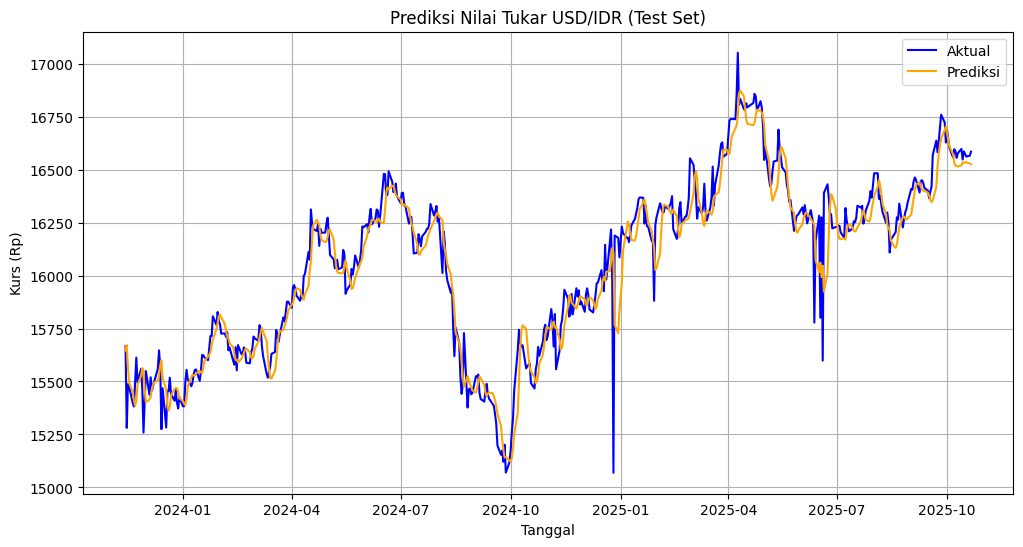

In [ ]:
# === 12. Visualisasi ===
plt.figure(figsize=(12,6))
plt.plot(results_test["Date"], results_test["Actual"], label="Aktual", color="blue")
plt.plot(results_test["Date"], results_test["Predict"], label="Prediksi", color="orange")
plt.title("Prediksi Nilai Tukar USD/IDR (Test Set)")
plt.xlabel("Tanggal")
plt.ylabel("Kurs (Rp)")
plt.legend()
plt.grid(True)
plt.show()

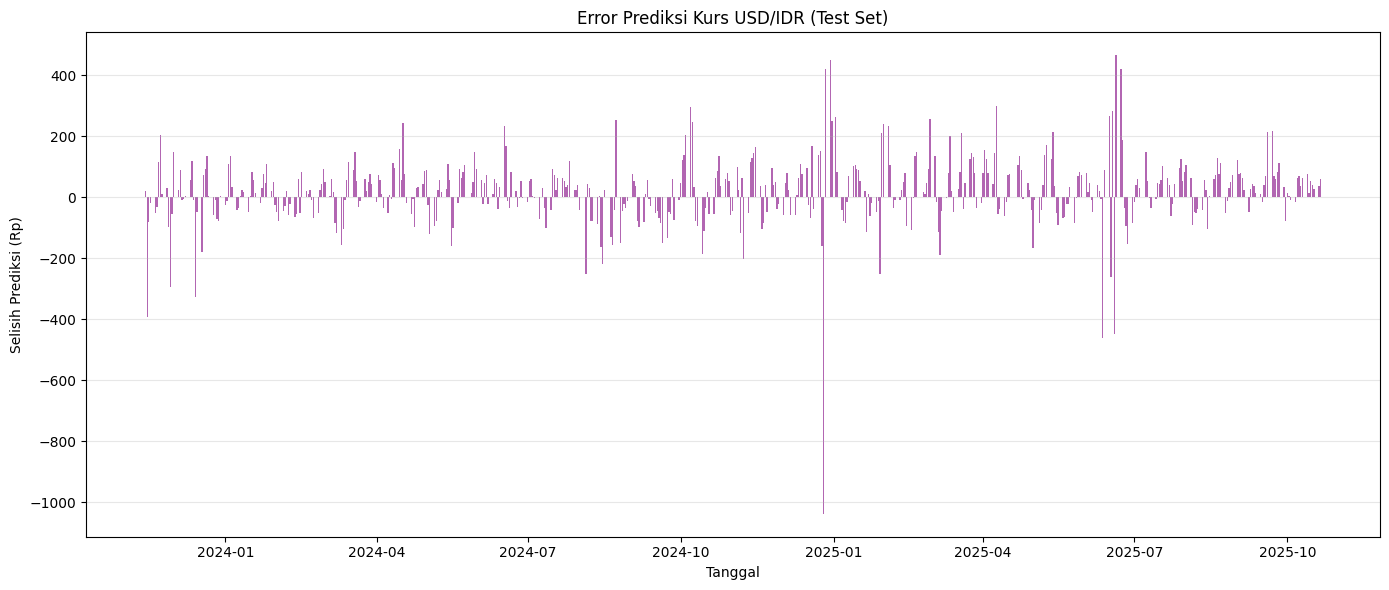

In [ ]:
## (b) Grafik 2 - Error per Tanggal
errors_test = results_test['Actual'] - results_test['Predict']
plt.figure(figsize=(14,6))
plt.bar(results_test['Date'], errors_test, color="purple", alpha=0.6)
plt.title("Error Prediksi Kurs USD/IDR (Test Set)")
plt.xlabel("Tanggal")
plt.ylabel("Selisih Prediksi (Rp)")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

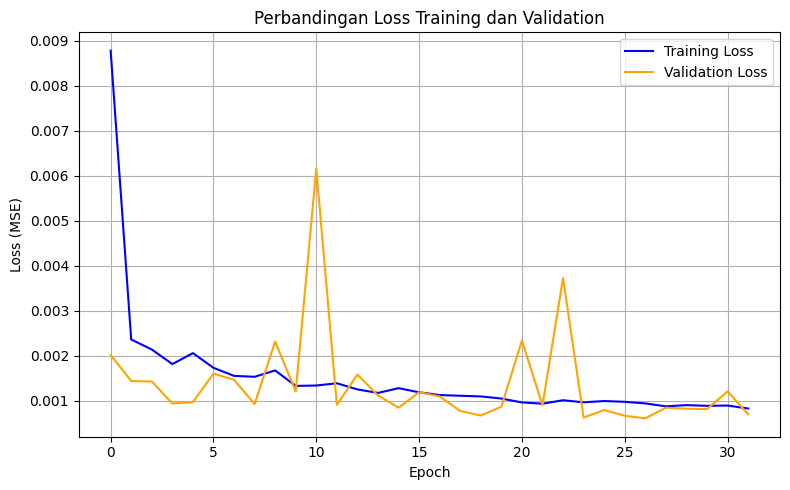


Visualisasi selesai. Grafik telah ditampilkan.


In [ ]:
## (c) Grafik 3 - Loss Training vs Validation
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title("Perbandingan Loss Training dan Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nVisualisasi selesai. Grafik telah ditampilkan.")

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


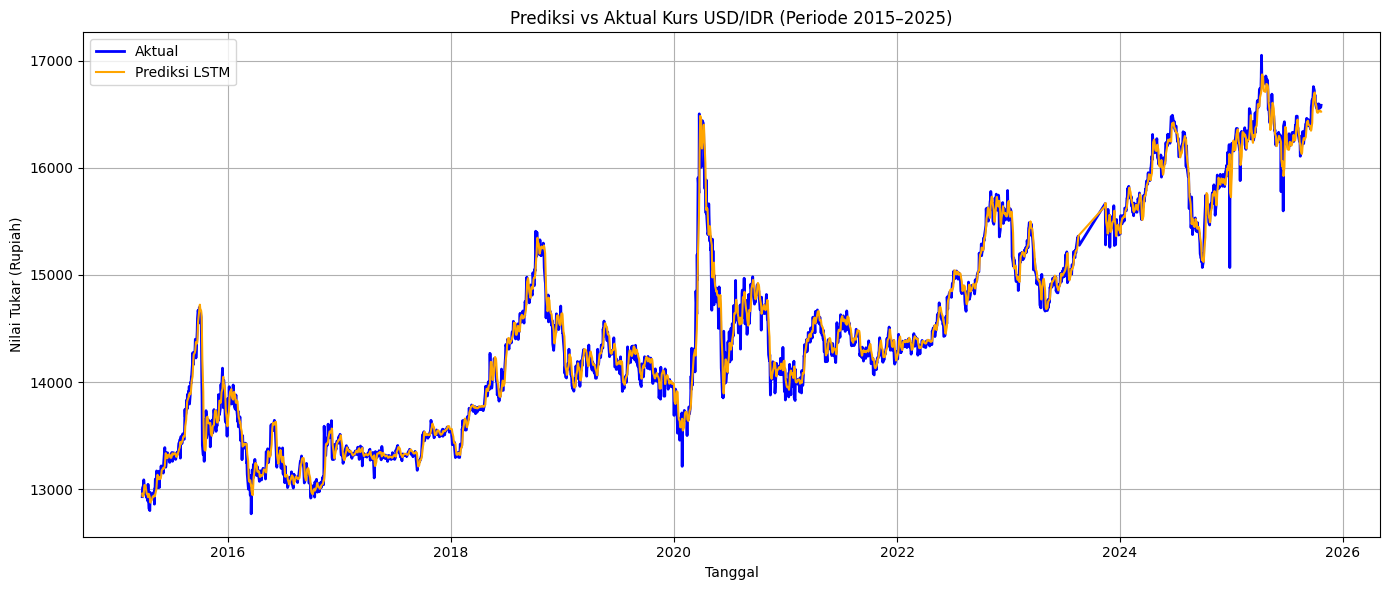

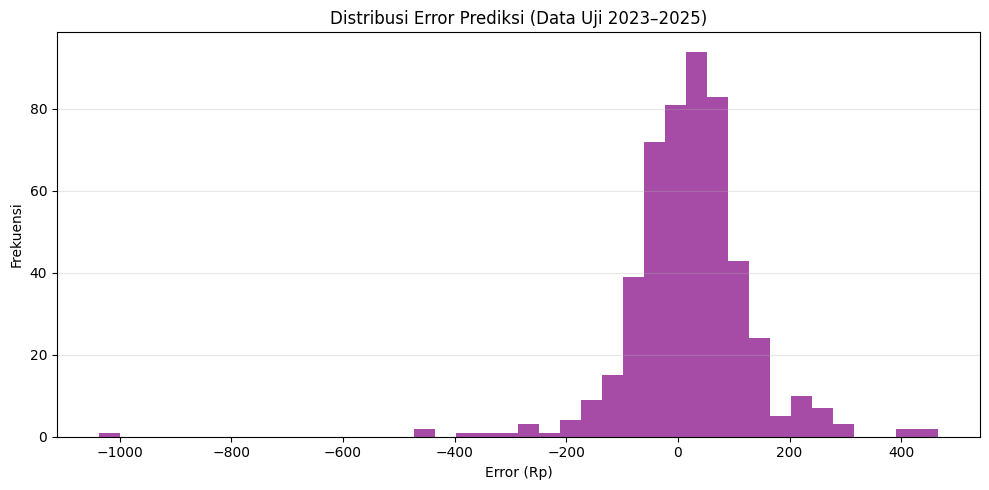

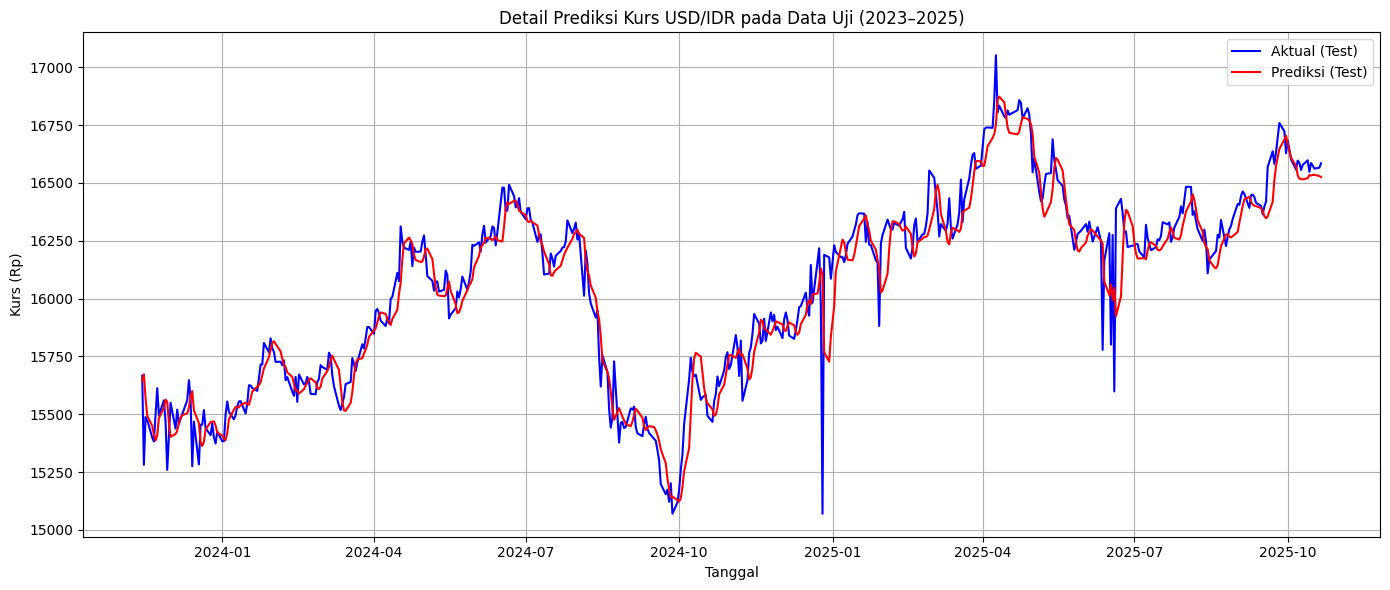


Visualisasi tambahan selesai: tren global, distribusi error, dan uji model.


In [ ]:
# === 13. Visualisasi tambahan (Uji Model & Tren Global) ===

# 1. Gabungkan hasil prediksi train + test
train_predict_full = scaler.inverse_transform(model.predict(X_train))
train_dates = close_data['Date'][time_step:train_size]

full_results = pd.DataFrame({
    "Date": pd.concat([train_dates, results_test["Date"]]).reset_index(drop=True),
    "Actual": pd.concat([
        pd.Series(y_train_inv.flatten()[:len(train_predict_full)]),
        pd.Series(y_test_inv.flatten()[:len(test_predict)])
    ]).reset_index(drop=True),
    "Predict": pd.concat([
        pd.Series(train_predict_full.flatten()),
        pd.Series(test_predict.flatten())
    ]).reset_index(drop=True)
})

# === (a) Plot keseluruhan hasil prediksi (train + test) ===
plt.figure(figsize=(14,6))
plt.plot(full_results["Date"], full_results["Actual"], label="Aktual", color="blue", linewidth=2)
plt.plot(full_results["Date"], full_results["Predict"], label="Prediksi LSTM", color="orange", linewidth=1.5)
plt.title("Prediksi vs Aktual Kurs USD/IDR (Periode 2015–2025)")
plt.xlabel("Tanggal")
plt.ylabel("Nilai Tukar (Rupiah)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === (b) Distribusi error prediksi (uji model) ===
errors_test = results_test['Actual'] - results_test['Predict']
plt.figure(figsize=(10,5))
plt.hist(errors_test, bins=40, color='purple', alpha=0.7)
plt.title("Distribusi Error Prediksi (Data Uji 2023–2025)")
plt.xlabel("Error (Rp)")
plt.ylabel("Frekuensi")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# === (c) Plot zoom prediksi 2023–2025 (uji model) ===
plt.figure(figsize=(14,6))
plt.plot(results_test["Date"], results_test["Actual"], label="Aktual (Test)", color="blue")
plt.plot(results_test["Date"], results_test["Predict"], label="Prediksi (Test)", color="red")
plt.title("Detail Prediksi Kurs USD/IDR pada Data Uji (2023–2025)")
plt.xlabel("Tanggal")
plt.ylabel("Kurs (Rp)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nVisualisasi tambahan selesai: tren global, distribusi error, dan uji model.")